# Clustering
- 비지도 학습 (Unsupervised Learning)
- 여러가지 방법으로 clustering 가능
- https://scikit-learn.org/stable/modules/clustering.html#clustering

# Unsupervised Learning
- Target, Label 값이 없는 data으로 학습
- 대표적으로 Density Estimation, Manifold Learning 등이 있다.


- **특정 형태의 data를 제대로 clustering하는 적합한 방법을 찾는 것이 목표**

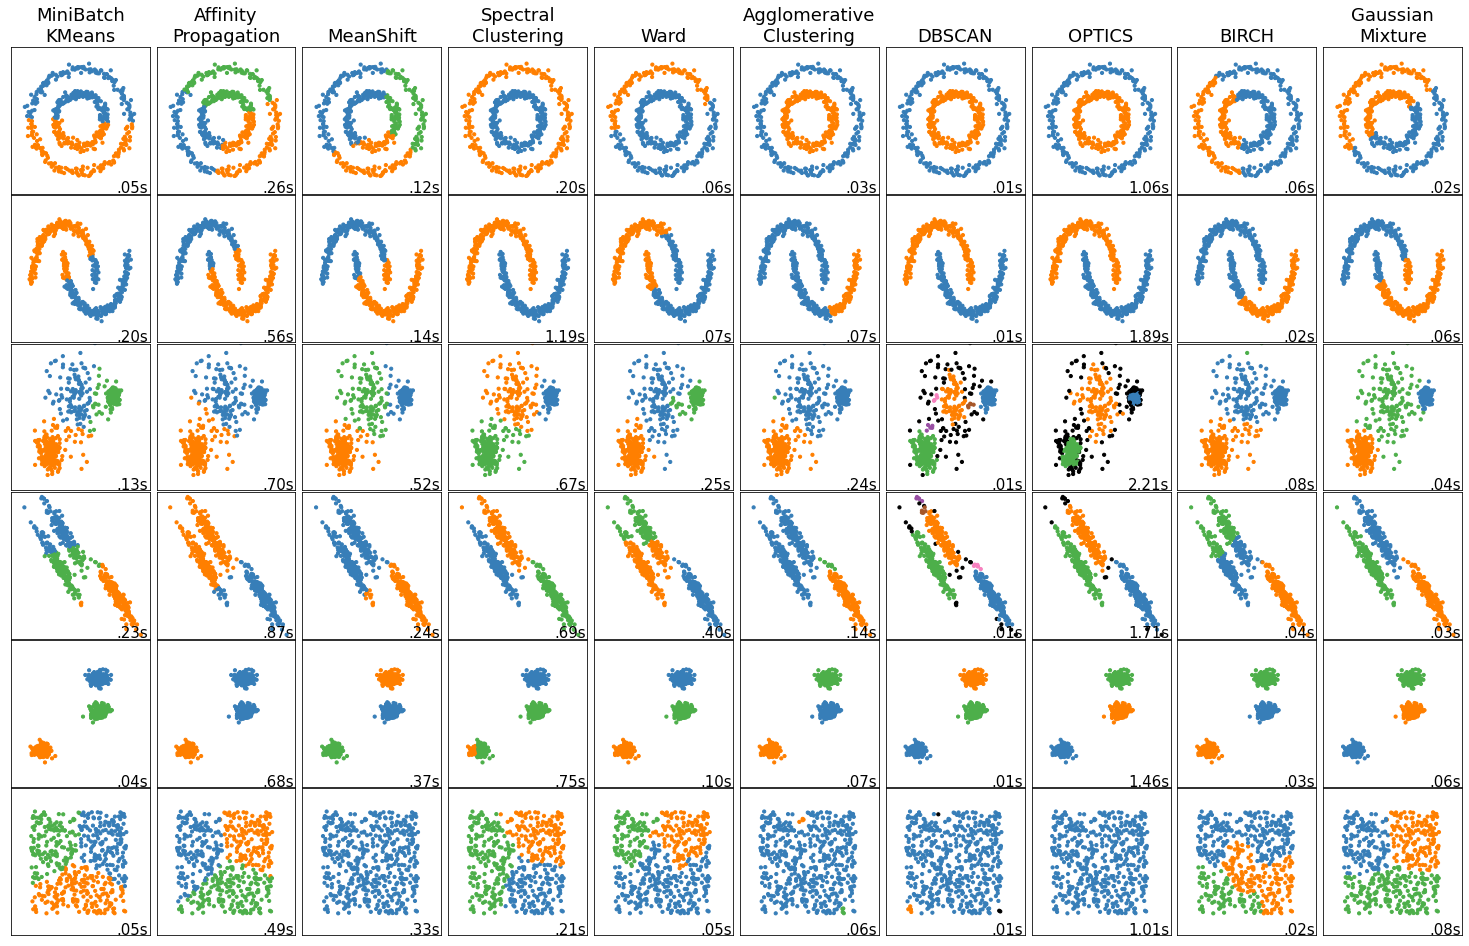

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

# K-Means
- 가장 기본적인 clustering 방법
- Input data
  - **군집의 개수**
- 초기 군집의 개수만큼의 random한 점을 잡는다.
- 새로운 점이 있을 때, 각 점사이의 거리를 계산해 가장 가까운 군집에 포함시킨다.
- 새로운 점이 포함된 군집은 군집내의 점들의 위치 평균 (Center of mass)를 계산하여 군집의 대표 위치로 잡는다. (지속적 업데이트)
- 위의 과정을 계속 반복하여 K개의 군집으로 분류한다.

# 결과  
- 군집 크기가 유사
- 군집의 형태가 원형

In [94]:
from sklearn import datasets, cluster

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Iris data를 활용한 Clustering

Index(['petal length (cm)', 'petal width (cm)'], dtype='object')


Text(0.5, 1.0, 'Real Cluster')

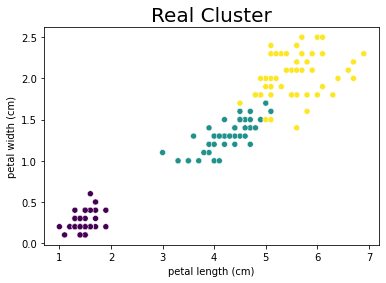

In [ ]:
iris = datasets.load_iris(as_frame = True)

X = iris.data.iloc[:, 2:4]
print(X.columns)
ax = sns.scatterplot(data = X, x = 'petal length (cm)', y = 'petal width (cm)', c = iris.target)
ax.set_title('Real Cluster', fontsize = 20)

- X로 2D array만 받음

[[4.26923077 1.34230769]
 [5.59583333 2.0375    ]
 [1.462      0.246     ]]
5


Text(0.5, 1.0, 'K-Means Cluster')

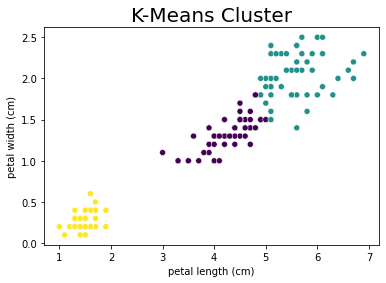

In [ ]:
cl = cluster.KMeans(n_clusters = 3).fit(X)

print(cl.cluster_centers_)  # centeroids의 좌표
print(cl.n_iter_)           # 반복 횟수
#print(cl.labels_)
ax = sns.scatterplot(data = X, x = 'petal length (cm)', y = 'petal width (cm)', c = cl.labels_)
ax.set_title('K-Means Cluster', fontsize = 20)

# Affinity propagation
- Input data (Optional)
  - **Preference**: 기준 데이터 허용 개수
  - **Damping**: 기준 데이터 적합성 점수 영향력 조절
- 랜덤으로 기준 데이터를 선정
- 기준 데이터로부터 가까운 점들끼리 clustering (K-Mean clustering과 유사)
- 데이터를 추가할 때마다 **기준 데이터의 적합성 검토**, 업데이트

29


Text(0.5, 1.0, 'Affinity propagation Cluster')

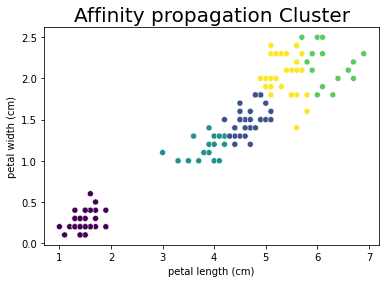

In [ ]:
ap = cluster.AffinityPropagation(damping = 0.7, max_iter = 10000).fit(X)

print(ap.n_iter_)           # 반복 횟수
#print(ap.labels_)
ax = sns.scatterplot(data = X, x = 'petal length (cm)', y = 'petal width (cm)', c = ap.labels_)
ax.set_title('Affinity propagation Cluster', fontsize = 20)

# Mean Shift
- Input data
  - bandwidth: 검사 영역 설정

12


Text(0.5, 1.0, 'Mean Shift Cluster')

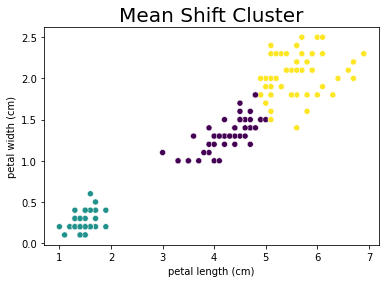

In [ ]:
ms = cluster.MeanShift().fit(X)

print(ms.n_iter_)           # 반복 횟수
#print(ms.labels_)
ax = sns.scatterplot(data = X, x = 'petal length (cm)', y = 'petal width (cm)', c = ms.labels_)
ax.set_title('Mean Shift Cluster', fontsize = 20)

# Spectral Clustering
- Input data
  - 군집의 개수 (K-Means와 유사)
- Affinity matrix를 만들어 K-Means 사용
- **연결이 되어 있으면서도 근처에 존재하는 점들을 clustering**
- **이미지 처리**에서 많이 사용

Text(0.5, 1.0, 'Spectral Clustering Cluster')

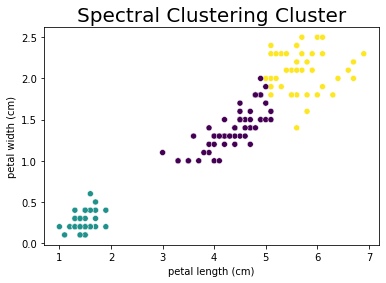

In [ ]:
sc = cluster.SpectralClustering(n_clusters = 3).fit(X)

ax = sns.scatterplot(data = X, x = 'petal length (cm)', y = 'petal width (cm)', c = sc.labels_)
ax.set_title('Spectral Clustering Cluster', fontsize = 20)

# Agglomerate Clustering
- 군집 개수 또는 군집 분할의 한계점 지정
- **계층화된 방식(Tree)**을 이용하여 군집 형성 
- BIRCH


Text(0.5, 1.0, 'Agglomerate Clustering Cluster')

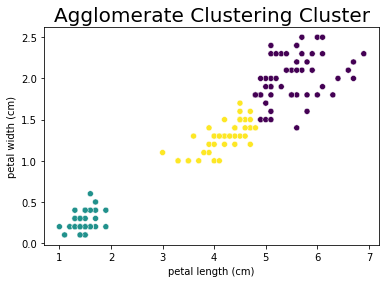

In [ ]:
ac = cluster.AgglomerativeClustering(n_clusters=3).fit(X)

ax = sns.scatterplot(data = X, x = 'petal length (cm)', y = 'petal width (cm)', c = ac.labels_)
ax.set_title('Agglomerate Clustering Cluster', fontsize = 20)

# DBSCAN
- min_samples: 밀집의 정도를 결정
- eps: 데이터 사이의 거리 (특정 값)
- 데이터의 **밀집도**에 따라 군집 형성


Text(0.5, 1.0, 'DBSCAN Cluster')

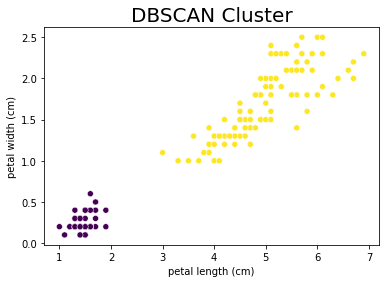

In [ ]:
db = cluster.DBSCAN(eps = 0.5).fit(X)

ax = sns.scatterplot(data = X, x = 'petal length (cm)', y = 'petal width (cm)', c = db.labels_)
ax.set_title('DBSCAN Cluster', fontsize = 20)

# OPTICS
- DBSCAN의 업그레이드 버전
- eps:데이터 사이의 거리 (범주화)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Text(0.5, 1.0, 'OPTICS Cluster')

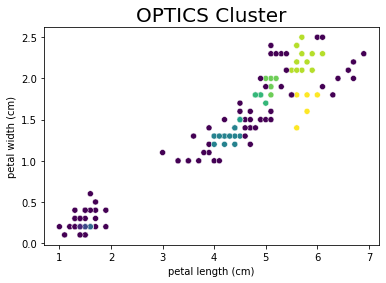

In [ ]:
op = cluster.OPTICS(eps = 0.5).fit(X)

ax = sns.scatterplot(data = X, x = 'petal length (cm)', y = 'petal width (cm)', c = op.labels_)
ax.set_title('OPTICS Cluster', fontsize = 20)

# Scores
- **Homogeneity**: 하나의 군집 (Cluster)에 하나의 분류가 있을 때 점수가 높음 (여러 label이 섞여 있으면 점수가 낮아짐)
- **Completeness**: 하나의 분류 (Class, Label)에 속하는 데이터가 하나의 군집 (Cluster)에 속함
- **V-measure**: $v = \frac{(1 + \beta) \times \text{homogeneity} \times \text{completeness}}{(\beta \times \text{homogeneity} + \text{completeness})}$
- 0.0 ~ 1.0
- **높을수록 좋음**


#Q. 비지도 학습이면 실제 label이 존재하지 않는데 scores를 어떻게 사용하는가?
- A. Silhouette Coefficient 등 실제 labels가 존재하지 않을 때 평가할 수 있는 scores도 존재함.
- 위의 scores는 model을 만들기 위한 pilot test에서 사용
- https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

# 활용 예제1
- Iris data의 petal_length, petal_width를 통한 clustering

# Attribute Information:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class:
-- Iris Setosa
-- Iris Versicolour
-- Iris Virginica

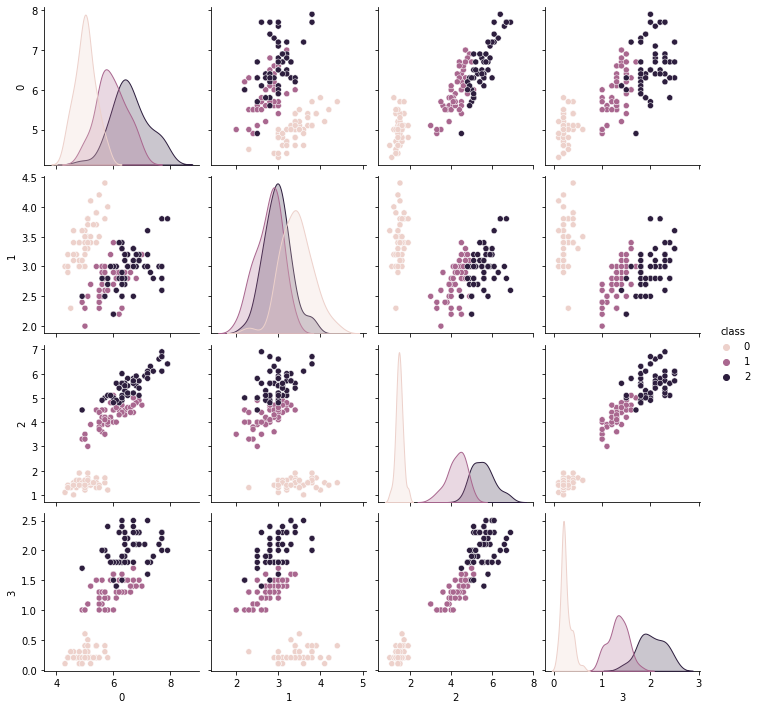

In [ ]:
pd_iris = pd.DataFrame(iris.data)
pd_iris['class'] = iris.target
sns.pairplot(data = pd_iris, hue = 'class')

In [95]:
def clustering_scores(y_true, y_pred):
  print('Homogeneity score: ', metrics.homogeneity_score(y_true, y_pred))
  print('Completeness score: ', metrics.completeness_score(y_true, y_pred))
  print('V-measure score: ', metrics.v_measure_score(y_true, y_pred))

In [96]:
from sklearn import metrics

X = iris.data[:, 2:4]
km = cluster.KMeans(n_clusters = 3).fit(X)
sns.scatterplot(x = X[:,0], y = X[:,1], c = km.labels_)

clustering_scores(iris.target, km.labels_)

TypeError: ignored

29


Text(0.5, 1.0, 'Affinity propagation Cluster')

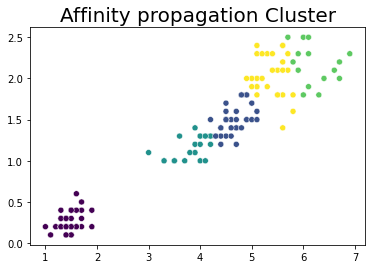

In [ ]:
ap = cluster.AffinityPropagation(damping = 0.7, max_iter = 10000).fit(X)

print(ap.n_iter_)           # 반복 횟수
#print(ap.labels_)
ax = sns.scatterplot(x = X[:,0], y = X[:,1], c = ap.labels_)
ax.set_title('Affinity propagation Cluster', fontsize = 20)

In [ ]:
ms = cluster.MeanShift().fit(X)

print(ms.n_iter_)           # 반복 횟수
#print(ms.labels_)
ax = sns.scatterplot(x = np.arange(len(X)), y = X, c = ms.labels_)
ax.set_title('Mean Shift Cluster', fontsize = 20)

ValueError: ignored

# 활용 예제2
- Dry beans dataset
- ShapeFactor1, 2, 3, 4를 이용하여 clustering
- 군집의 개수 = 7 (Class = 7)

In [97]:
bean_data = pd.read_csv('/content/drive/MyDrive/인공지능 학습/Data/Dry_Bean_Dataset.csv')
#print(bean_data)

X = bean_data.iloc[:,12:16] # ShapeFactor1, 2, 3, 4
X['Class'] = bean_data['Class']
print(X)

       ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4     Class
0          0.007332      0.003147      0.834222      0.998724     SEKER
1          0.006979      0.003564      0.909851      0.998430     SEKER
2          0.007244      0.003048      0.825871      0.999066     SEKER
3          0.007017      0.003215      0.861794      0.994199     SEKER
4          0.006697      0.003665      0.941900      0.999166     SEKER
...             ...           ...           ...           ...       ...
13606      0.006858      0.001749      0.642988      0.998385  DERMASON
13607      0.006688      0.001886      0.676099      0.998219  DERMASON
13608      0.006681      0.001888      0.676884      0.996767  DERMASON
13609      0.006724      0.001852      0.668237      0.995222  DERMASON
13610      0.007001      0.001640      0.616221      0.998180  DERMASON

[13611 rows x 5 columns]


# K-Means

In [ ]:
km = cluster.KMeans(n_clusters = 7).fit(X.iloc[:,:4])

clustering_scores(bean_data['Class'], km.labels_)

Homogeneity score:  0.4217119659203924
Completeness score:  0.415371339239421
V-measure score:  0.4185176385143653


# 정답

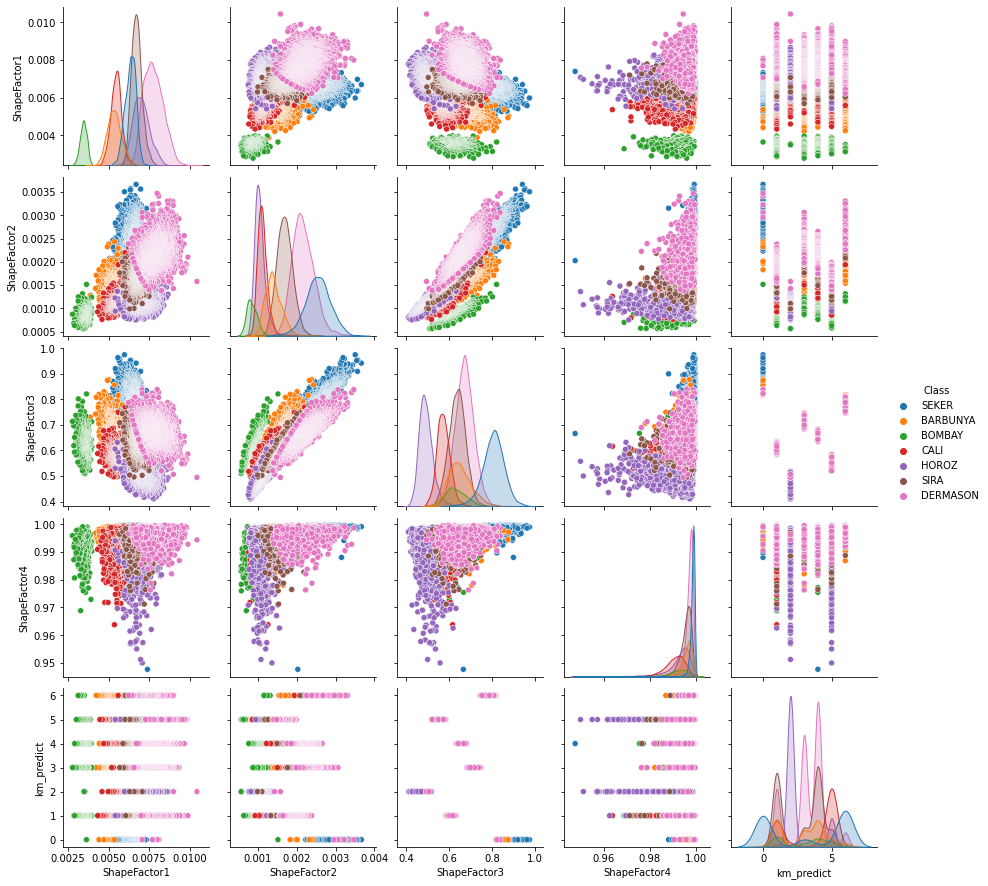

In [ ]:
bean = X
bean['Class'] = bean_data['Class']
X['km_predict'] = km.labels_
sns.pairplot(X, hue = 'Class')

# K-Means Clustering

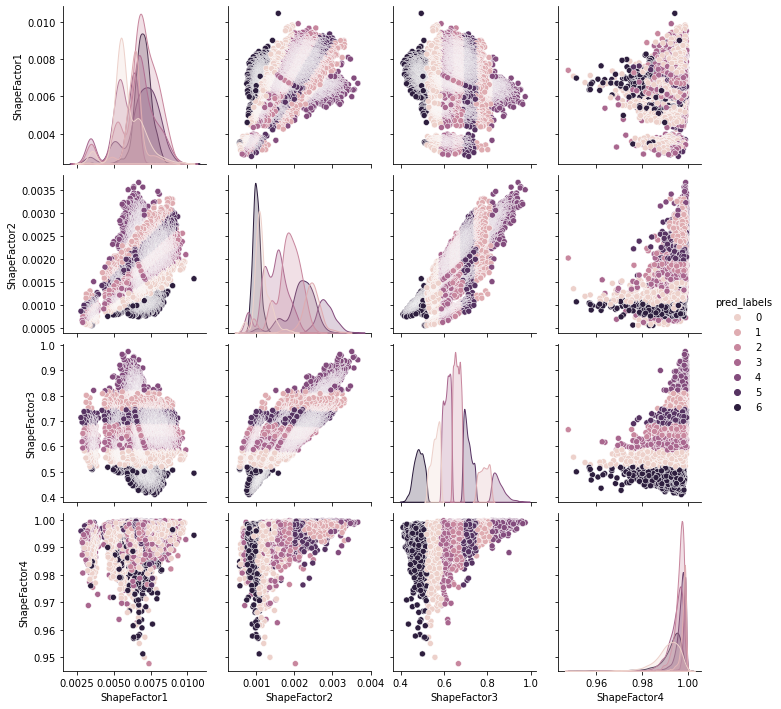

In [ ]:
sns.pairplot(X, hue = 'km_predict')

# Spectral Clustering

In [ ]:
#X = bean_data.iloc[:,12:16]
sc = cluster.SpectralClustering(n_clusters = 7).fit(X.iloc[:,:4])
clustering_scores(bean_data['Class'], sc.labels_)

KeyboardInterrupt: ignored

In [ ]:
X['sp_predict'] = sc.labels_
sns.pairplot(X.iloc[:,:4], hue = 'sp_predict')

# OPTICS Clustering

In [ ]:
op = cluster.OPTICS().fit(X.iloc[:,:4])
clustering_scores(bean_data['Class'], op.labels_)

Homogeneity score:  0.27932759857675576
Completeness score:  0.19414811643870436
V-measure score:  0.2290758550573301


In [ ]:
print(op.labels_)
#sns.pairplot(X.iloc[:,:4], hue = op.labels_)

[ -1 554  -1 ... 162 277  -1]


Ward

In [99]:
ward = cluster.AgglomerativeClustering(n_clusters = 7, linkage = 'ward').fit(X.iloc[:,:4])
clustering_scores(bean_data['Class'], ward.labels_)

Homogeneity score:  0.40431013169585867
Completeness score:  0.39462633658784957
V-measure score:  0.3994095461914246


In [100]:
db = cluster.DBSCAN().fit(X.iloc[:,:4])
clustering_scores(bean_data['Class'], db.labels_)

Homogeneity score:  1.2103942908065617e-16
Completeness score:  1.0
V-measure score:  2.420788581613123e-16


In [101]:
ms = cluster.MeanShift().fit(X.iloc[:,:4])
clustering_scores(bean_data['Class'], ms.labels_)

Homogeneity score:  1.2103942908065617e-16
Completeness score:  1.0
V-measure score:  2.420788581613123e-16


In [ ]:
ap = cluster.AffinityPropagation(damping = 0.7, max_iter = 10000).fit(X.iloc[:,:4])
clustering_scores(bean_data['Class'], ap.labels_)